# RA2CE feature: Direct analysis

Three types of damage curves can be introduced to this analysis:
- Huizinga
- OSdaMage 
- User defined

## An example for the OSdamage damage function

In this notebook, we provide an example for an event-based object-oriented Huizinga analysis.

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import rasterio

root_dir = Path(".\\data\\direct_analysis_OSdamage")
assert root_dir.exists(), "root_dir not found."

#### Introducing a hazardous event

To use the flood map with RA2CE, we need to fill in the **[hazard]** section in the network.ini. 

Specify the flood map name in the **hazard_map** parameter in network.ini. RA2CE expects the flood map to be located in the *hazard* folder. The **aggregate_wl** parameter in analysis.ini can be set to either 'max', 'min' or 'mean' to take the maximum, minimum or mean water depth per road segment when the exposure of the roads to a certain hazard (map) is determined.<br>

Set the right CRS for the flood map in the **hazard_crs** parameter. This CRS can be different from the origins, destinations and road network. RA2CE will reproject the network to the CRS of the flood map and will reproject the road back to the original CRS when the CRS differs.

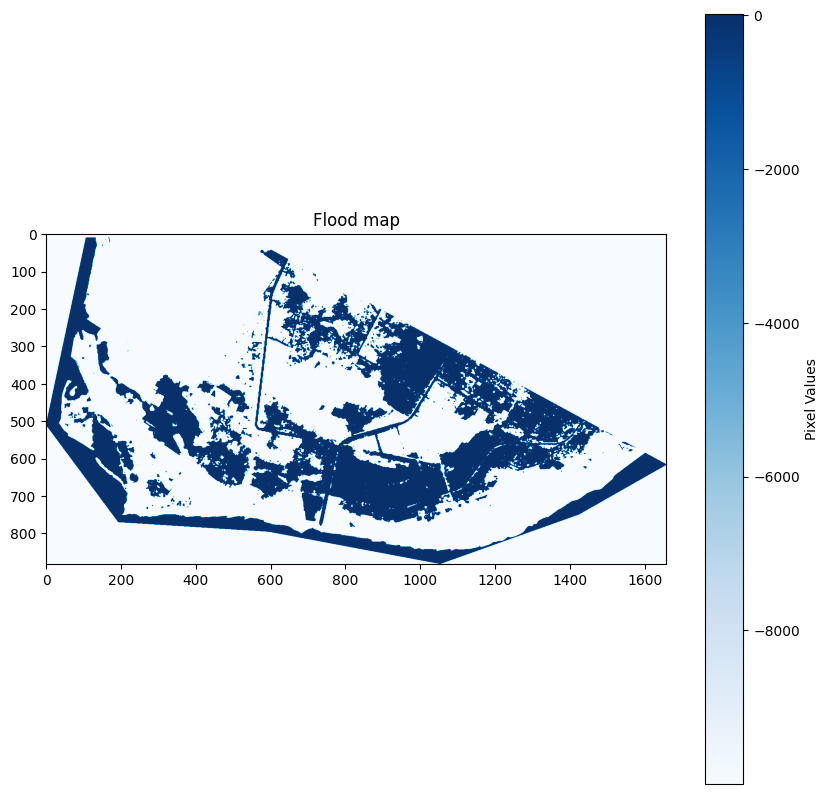

In [3]:
hazard_folder = root_dir / "static" / "hazard" # find the hazard folder where you locate your floo dmap
hazard_map = hazard_folder / "max_flood_depth.tif" # set the location of the hazard map

# Open the TIF file using rasterio
with rasterio.open(hazard_map) as src:
    # Read the TIF file as a numpy array
    tif_array = src.read(1)  # Change the band index (1) if necessary

plt.figure(figsize=(10, 10))
plt.imshow(tif_array, cmap='Blues')  # Change the colormap if desired
plt.colorbar(label='Pixel Values')
plt.title('Flood map')
plt.show()


#### Specifying the .ini files

**Network.ini content**
<br>
<br>
> [project]<br>
name = beira<br>
<br>
[network]<br>
**directed = False<br>
source = OSM download<br>
primary_file = None<br>
diversion_file = None<br>
file_id = rfid_c<br>
polygon = region_polygon.geojson<br>
network_type = drive<br>
road_types = motorway,motorway_link,primary,primary_link,secondary,secondary_link,tertiary,tertiary_link,residential<br>
save_gpkg = True
<br>
[origins_destinations]<br>
**origins = None<br>
destinations = None<br>
origins_names = None<br>
destinations_names = None<br>
id_name_origin_destination = None<br>
origin_count = None<br>
origin_out_fraction = None<br>
category = category**<br>
<br>
[hazard]<br>
**hazard_map = max_flood_depth.tif<br>
hazard_id = None<br>
hazard_field_name = waterdepth<br>
aggregate_wl = max<br>
hazard_crs = EPSG:32736**<br>
<br>
*[cleanup]<br>
snapping_threshold = None<br>
segmentation_length = None<br>
merge_lines = True<br>
merge_on_id = False<br>
cut_at_intersections = False<br>*

We now need to update our analysis initialisation files using the preferred OD-analysis (there are multiple). We will consider the **direct** analysis. With the **aggregate_wl** parameter, the user can choose which type of aggregation of the water level on the road segment (max, mean, min) the analysis should consider. For the direct analysis, the **aggregate_wl=mean** makes sense. 

The **damage_curve** defines the damage curve type. ‘HZ’ to use the Huizinga damage function, ‘OSD’ to use the OSdaMage functions, and ‘MAN’ to use damage functions from manually inserted files. The **event_type** defines the type of the hazardous event, which is either 'event', or 'return_period'. The former is an one-time event, while the later will be applied for the events witha probability of occurance.

**[analysis1]**
<br>
<br>
name = OSdamage_direct_damage_event<br>
analysis = direct<br>
event_type = event<br>
damage_curve = OSD<br>
save_csv = True<br>
save_gpkg =True<br>

Set the paths to the initialization files and check if the files exist.

In [4]:
from ra2ce.ra2ce_handler import Ra2ceHandler
from ra2ce.network.network_config_data.network_config_data_reader import NetworkConfigDataReader
from ra2ce.analysis.analysis_config_data.analysis_config_data_reader import AnalysisConfigDataReader

# Load network data.
_network_config_data = NetworkConfigDataReader().read(root_dir.joinpath("network.ini"))

# Load analysis data.
_analysis_config_data = AnalysisConfigDataReader().read(root_dir.joinpath("analysis.ini"))

_analysis_config_data.input_path = root_dir.joinpath("input_analysis_data")

c:\repos\ra2ce\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Run RA2CE.

In [5]:
handler = Ra2ceHandler.from_config(_network_config_data, _analysis_config_data)

handler.configure()
handler.run_analysis()

2024-05-14 09:38:51 AM - [hazard_overlay.py:705] - root - WARNING - Hazard crs EPSG:32736 and gdf crs {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "directi

[AnalysisResultWrapper(analysis_result=          osmid  oneway   infra_type  reversed  length  rfid_c  rfid  \
 0      44785078    True     tertiary     False    35.0       1     2   
 1     820923407   False     tertiary      True    70.0       2     1   
 2      44794760   False     tertiary     False    12.0       3  3263   
 3      44794760   False     tertiary      True    17.0       4  1088   
 4      44794760   False     tertiary     False    14.0       5  1087   
 ...         ...     ...          ...       ...     ...     ...   ...   
 9919  385433485   False  residential      True   168.0    9920  3956   
 9920  590994767   False  residential     False    25.0    9921  3434   
 9921  590994767   False  residential      True   179.0    9922  3479   
 9922  385433485   False  residential     False    82.0    9923  3955   
 9923  385433485   False  residential      True   114.0    9924  2184   
 
                            name maxspeed  lanes  ... dam_C2_EV1_quartiles  \
 0    

#### Visualising the results

In [6]:
analysis_output_path = root_dir / "output" / "direct"
damage_gdf = gpd.read_file(analysis_output_path / 'OSdamage_direct_damage_event.gpkg')
damage_gdf.head() #show the origins

,osmid,oneway,infra_type,reversed,length,rfid_c,rfid,name,maxspeed,lanes,...,dam_C2_EV1_representative,dam_C3_EV1_quartiles,dam_C3_EV1_representative,dam_C4_EV1_quartiles,dam_C4_EV1_representative,dam_C5_EV1_quartiles,dam_C5_EV1_representative,dam_C6_EV1_quartiles,dam_C6_EV1_representative,geometry
0,44785078,True,tertiary,False,35.0,1,2,None,None,2.0,...,None,nan,None,nan,None,nan,NaN,nan,NaN,"LINESTRING (34.87673 -19.85047, 34.87642 -19.8..."
1,820923407,False,tertiary,True,70.0,2,1,Ava Mártires da Revolução,60,2.0,...,None,nan,None,nan,None,nan,NaN,nan,NaN,"LINESTRING (34.87673 -19.85047, 34.87737 -19.8..."
2,44794760,False,tertiary,False,12.0,3,3263,Rua Carlos Pereira,60,2.0,...,None,nan,None,nan,None,nan,NaN,nan,NaN,"LINESTRING (34.89940 -19.84205, 34.89937 -19.8..."
3,44794760,False,tertiary,True,17.0,4,1088,Rua Carlos Pereira,60,2.0,...,None,nan,None,nan,None,nan,NaN,nan,NaN,"LINESTRING (34.89940 -19.84205, 34.89943 -19.8..."
4,44794760,False,tertiary,False,14.0,5,1087,Rua Carlos Pereira,60,2.0,...,None,nan,None,nan,None,nan,NaN,nan,NaN,"LINESTRING (34.89778 -19.84420, 34.89767 -19.8..."
